# 프로젝트 : 고양이 수염 스티커 만들기

**Rubric**

|평가문항|상세기준|
|---|---|
| 1. 자기만의 카메라앱 기능 구현을 완수하였다 | 얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.|
| 2. 스티커 이미지를 정확한 원본 위치에 반영하였다.| 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.|
|3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.|얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.


**목차**
1. 스티커 준비하기 및 라이브러리 호출
2. 얼굴 검출 & 랜드마크 검출하기
3. 스티커 적용 위치 확인하기
4. 스키터 적용하기
5. 문제점 찾아보기
6. 회고
7. Reference

## 1. 스티커 준비하기 및 라이브러리 호출


(1) 고양이 수염 스티커

(2) 적용할 이미지 가져오기

In [1]:
## 라이브러리 불러오기
import cv2
import dlib
import os 
import matplotlib.pyplot as plt 
import numpy as np 

print(cv2.__version__)
print(dlib.__version__)

4.7.0
19.24.1


적용할 고양이 수염 스터커 이미지

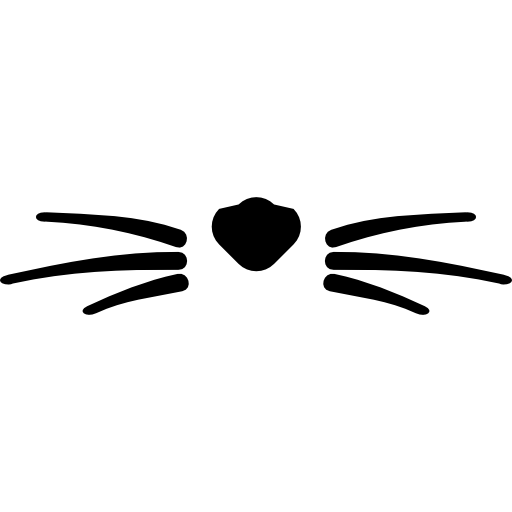

---
이제 스티커 이미지를 적용할 사진을 불러온다

In [2]:
# 적용할 이미지 불러오기
image_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Data/sticker_app/images/서현진.png' 
img_bgr = cv2.imread(image_path)    # OpenCV로 이미지를 불러오기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) ## RGB로 바꾸기

img_show_bgr = img_bgr.copy()
img_show_rgb = img_rgb.copy()      # 출력용 이미지를 따로 보관

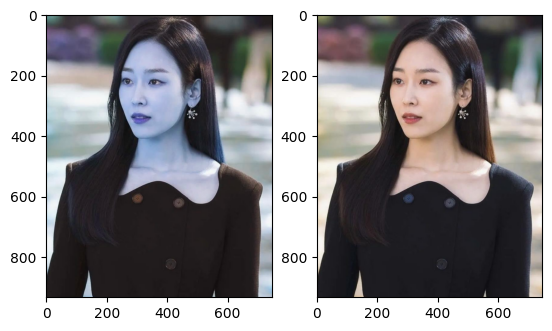

In [3]:
plt.subplot(1,2,1)
plt.imshow(img_bgr)

plt.subplot(1,2,2)
plt.imshow(img_rgb)
plt.show()

- Open CV는 BGR 이미지로 반환하는데, dlib은 RGB 이미지를 입력으로 받기 때문에 RGB로 바꿔주어야 한다.
- 왼쪽 사진을 보면 BGR 형태이기 때문에 피부색이 파랗게 나온다. RGB로 바꿔주면 2번째 사진처럼 우리가 아는 정상적인 사진이 나온다

## 2. 얼굴 검출 & 랜드마크 검출하기

 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾기

In [4]:
# 기본 얼굴 감지기를 반환
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용하여 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb, 2)   # (image, num of image pyramid)

- dlib은 rgb값을 받기 때문에 img_rgb로 넣어준다

rectangles[[(198, 148) (429, 379)]]


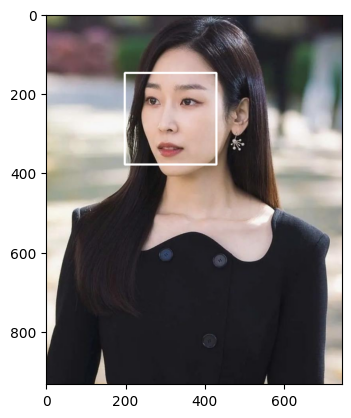

In [5]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    
    # cv.rectangle(img, pt1, pt2, color[, thickness[, lineType[, shift]]])
    cv2.rectangle(img_show_rgb, (l,t), (r,b), (255,255,255), 3, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

plt.imshow(img_show_rgb)
plt.show()

___
Dlib에서 제공하는 ibug 300-W 데이터셋으로 학습한 pretrained model을 사용한다.

In [6]:
model_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Data/sticker_app/model/shape_predictor_68_face_landmarks.dat'   
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

Q. dlib.rectangle이 있는데 cv2 메소드를 사용한 이유는?

In [7]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냄
# face landmark 좌표를 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


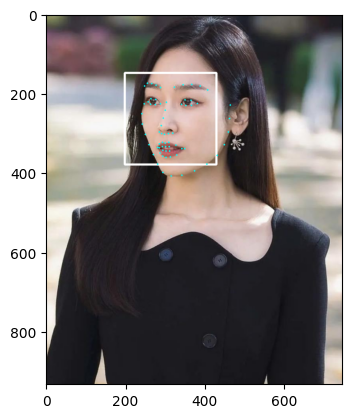

In [8]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_rgb, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show_rgb 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

plt.imshow(img_show_rgb)
plt.show()

In [9]:
# 얼굴의 좌표를 확인

# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(290, 281)
(x,y) : (290,165)
(w,h) : (232,232)


## 3. 스티커 적용 위치 확인하기

고양이 수염이 적용될 위치를 landmark를 사용하여 계산하기

In [10]:
# 준비된 스티커 이미지를 읽어서 적용하기
sticker_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Data/sticker_app/images/고양이 수염1.png' # 수염 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수// cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 수염 이미지의 차원 확인

(232, 232, 3)


In [11]:
# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 부위의 x값
# y는 이미지에서 코 부위의 y값
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수

refined_x = x - w // 2 
refined_y = y 

# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정. 이미지 시작점은 top-left 좌표이기 때문
# 즉, refined_x, refined_y값에서 고양이 수염 이미지가 시작됨

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (174,165)


#### 스티커가 이미지 바깥에 위치할 경우

In [12]:
## 스티커가 이미지 바깥에 위치되는 경우에 지정해주면 됨

# 스티커가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 적용할 스티커 이미지를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 스티커 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (174,165)


___

In [13]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

sticker_area = img_show_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]


# 수염 스티커에서 255이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 뜻
# 그렇기 때문에 255인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 255일 경우(수염 스티커에서 수염 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(수염 이미지)를 적용한다.

img_show_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

## 4. 스티커 적용하기

(1) np.where 를 사용해서 스티커를 적용하기

(2) 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다. opencv 의 cv2.addWeighted() 를 참고

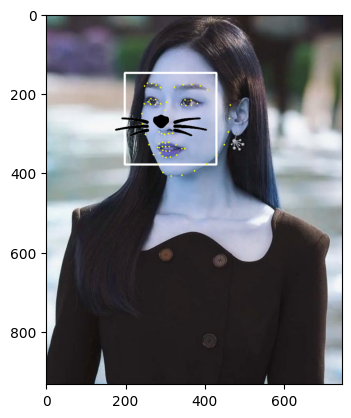

In [14]:
# 수염 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역과 랜드마크를 미리 적용해놓은 img_show_rgb에 수염 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show_rgb, cv2.COLOR_BGR2RGB))
plt.show()

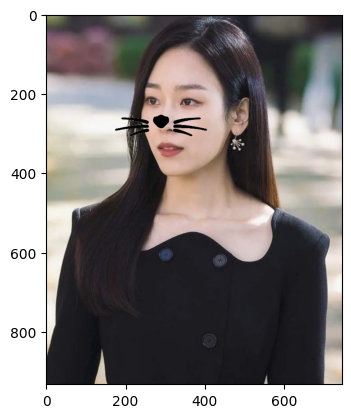

In [15]:
# bounding box와 landmark를 제거하고 최종 결과만 출력
# img_show대신 img_bgr 활용
# 고양이수염 이미지
sticker_area = img_rgb[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_rgb[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(img_rgb) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

- 코 위치에 맞게 귀여운 고양이 수염을 단 이미지가 형성 되었다.

## #함수로 만들어 적용하기

In [29]:
def cat_sticker(image, stiker):
  # 이미지 경로 지정
  path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Data/sticker_app/images/'
  image_path = os.path.join(path, image)
  # image_path = os.path.join(path, image)

  # 이미지 저장
  img_bgr = cv2.imread(image_path)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  img_show = img_rgb.copy()


  # 얼굴 감지 및 bounding box 추출
  detector_hog = dlib.get_frontal_face_detector()
  dlib_rects = detector_hog(img_rgb, 1)

  # 얼굴 좌표
  for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
  # plt.imshow(img_show)

  # model 불러오기
  model_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Data/sticker_app/model/shape_predictor_68_face_landmarks.dat'
  landmark_predictor = dlib.shape_predictor(model_path)

  # 랜드마크
  list_landmarks = []
  for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
  
  for landmark in list_landmarks:
    for point in landmark:
      cv2.circle(img_show, point, 3, (0, 255, 255), -1)


  # 얼굴 좌표 확인
  for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0] 
    y = landmark[30][1] - dlib_rect.height()//2 
    w = h = dlib_rect.width()

  sticker_path = os.path.join(path, stiker)
  img_sticker = cv2.imread(sticker_path) 
  img_sticker = cv2.resize(img_sticker, (w,h))

  refined_x = x - w // 2 
  refined_y = y

  sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
  img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

  img_rgb[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
  plt.imshow(img_rgb) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
  plt.show()


(153, 198)


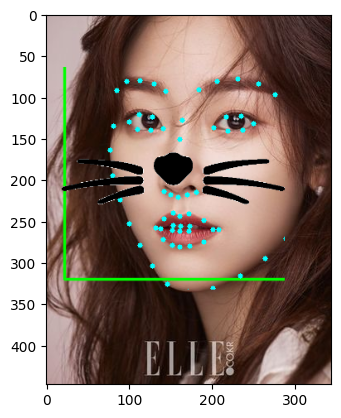

In [30]:
cat_sticker('서현진1.jpg', '고양이 수염1.png')

In [18]:
def stiker(x):
  path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Data/sticker_app/images/'
  # sticker_path =  os.path.join(path, x)
  sticker_path =  path.join(path, x)
  img_sticker = cv2.imread(sticker_path)
  img_sticker = cv2.resize(img_sticker, (w,h))

  refined_x = x - w // 2 
  refined_y = y
  print (f'(x,y) : ({refined_x},{refined_y})')
  sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
  img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

  img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
  np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
  plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
  plt.show()

## 5. 문제점 찾아보기

(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보기

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보기.

> 생각해볼 수 있는 문제점
- 얼굴 각도에 따라 스티커가 어떻게 변해야 할지
- 멀리서 촬영하면 왜 안될지? 옆으로 누워서 하면 왜 안되는지?
- 실행속도 중요?
- 스태커앱을 만들 때 정확도가 얼마나 중요한지?

- gif, jpg 사진에도 적용이 될 지 해보기
- 여러가지 모양의 스티커를 적용해보기, 각 스티커마다 따로 지정해서 앱 처럼 만들어보기
- 사람 여러명일때 적용해보기
- 크롭이 되어있는 스티커 적용해보기

sticker_area 줄이 두 줄이길래 지웠는데 앞에 이미지 이름이 달랐어요
박스랑 점 있는 얼굴 img_show, 없는 얼굴 img_bar

## 회고

1. 새로 알게 된 것
  
  (1) 이미지 피라미드


  (2) cv


  (3) dlib

2. 궁금했던 것

  (1) bounding box 만들기
  
  bounding box를 만들 때, cv2.retangle에 이미지를 어떤 것으로 지정하느냐에 따라 bounging box가 표시되는 경우가 있었고 아닌 경우가 있었다. 그래서 어떤 것을 넣었을 때 되고 안되는지 정확히 알아보기 위한 시도를 해 보았다.

  첫 번째 시도 : img_rgb ❌-> img_show_rgb⭕ -> img_show_bgr⭕ -> img_bgr⭕\
  두 번째 시도 : img_bgr ❌ -> img_rgb ❌ -> img_show_bgr❌-> img_show_rgb ⭕\
  세 번째 시도 : img_show_bgr⭕ -> img_bgr ⭕ -> img_rgb ⭕ -> img_show_rgb ⭕

  실험해 본 결과 이미지를 카피한 img_show_rgb,bgr은 바로 bounding box가 만들어졌고, 나머지는 아니었다.
  먼저 img_show_rgb,bgr로 만든 다음에 원본 이미지를 넣었을 때는 코드가 덮어씌여져서 바운딩박스가 나타나는 것 같았다.

  그런데 왜 카피한 이미지는 되고, 원본 이미지는 안 되는지 아직 알아내지 못했다.


  (2) 최종 결과 출력

  



## Reference

- open CV (https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html)
- 적용 이미지 다운로드 (https://www.pinterest.co.kr/search/pins/?q=%EC%84%9C%ED%98%84%EC%A7%84&rs=typed)
- 고양이 수염 다운로드 (https://www.pinterest.co.kr/search/pins/?q=%EA%B3%A0%EC%96%91%EC%9D%B4%20%EC%88%98%EC%97%BC%20%EC%8A%A4%ED%8B%B0%EC%BB%A4&rs=typed)
- 얼굴 감지기 (https://hayunjong83.tistory.com/38)
- cv2.retanle (https://docs.opencv.org/4.7.0/d6/d6e/group__imgproc__draw.html#ga07d2f74cadcf8e305e810ce8eed13bc9)
- 스티커 회전 방법 (https://velog.io/@dldndyd01/OpenCV-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%9A%8C%EC%A0%84%EC%A4%91%EC%95%99-%EA%B8%B0%EC%A4%80-%ED%9A%8C%EC%A0%84-cv2.getRotationMatrix2D-%EC%96%BC%EA%B5%B4-%ED%9A%8C%EC%A0%84-%EA%B0%81%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0)
- 마크다운 표 만들기(https://inasie.github.io/it%EC%9D%BC%EB%B0%98/%EB%A7%88%ED%81%AC%EB%8B%A4%EC%9A%B4-%ED%91%9C-%EB%A7%8C%EB%93%A4%EA%B8%B0/)